In [1]:
import torch
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, multilabel_confusion_matrix
import random
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from datasets import load_dataset
import numpy as np

dataset = load_dataset("go_emotions")
dataset = dataset.filter(lambda x: len(x["labels"]) > 0)

emotion_labels = dataset["train"].features["labels"].feature.names
NUM_LABELS = len(emotion_labels)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [3]:
def labels_to_multihot(label_lists, num_labels):
    y = np.zeros((len(label_lists), num_labels), dtype=int)
    for i, labels in enumerate(label_lists):
        for l in labels:
            y[i, l] = 1
    return y


In [4]:
y_train = labels_to_multihot(dataset["train"]["labels"], NUM_LABELS)
y_val   = labels_to_multihot(dataset["validation"]["labels"], NUM_LABELS)

print(y_train.shape, y_val.shape)


(43410, 28) (5426, 28)


In [5]:
assert y_train.ndim == 2 and y_train.shape[1] == NUM_LABELS


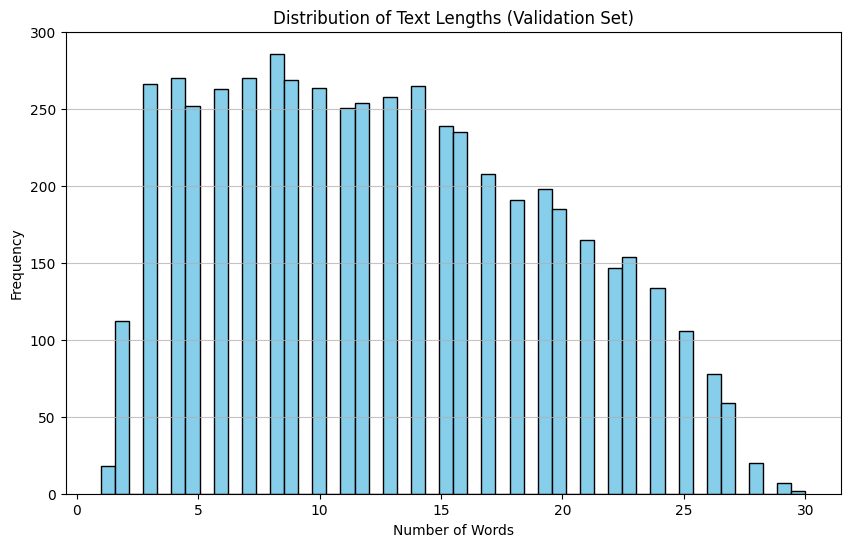

In [63]:
text_lengths = [len(text.split()) for text in dataset["validation"]["text"]]

plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths (Validation Set)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

DistilBERT

In [6]:
from transformers import DistilBertTokenizerFast

tokenizer_distil = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

def tokenize_distil(batch):
    return tokenizer_distil(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

dataset_distil = dataset.map(tokenize_distil, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [7]:
def encode_labels(example):
    label_vec = [0.0] * NUM_LABELS
    for l in example["labels"]:
        label_vec[l] = 1.0
    example["labels"] = label_vec
    return example

dataset_distil = dataset_distil.map(encode_labels)

dataset_distil.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [8]:
import torch
from transformers import DistilBertForSequenceClassification

model_distil = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [9]:
from transformers import Trainer

class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fn = torch.nn.BCEWithLogitsLoss()
        loss = loss_fn(logits, labels.float())

        return (loss, outputs) if return_outputs else loss


In [10]:
from transformers import TrainingArguments

training_args_distil = TrainingArguments(
    output_dir="./distilbert_emotion",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    logging_steps=100,
    disable_tqdm=False,
    report_to="none"
)


In [11]:
trainer_distil = MultilabelTrainer(
    model=model_distil,
    args=training_args_distil,
    train_dataset=dataset_distil["train"],
    eval_dataset=dataset_distil["validation"]
)

trainer_distil.train()


Epoch,Training Loss,Validation Loss
1,0.089758,0.088818
2,0.082048,0.084245
3,0.073309,0.084234
4,0.065969,0.086527
5,0.057556,0.088177


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=13570, training_loss=0.0804785324706694, metrics={'train_runtime': 2824.5596, 'train_samples_per_second': 76.844, 'train_steps_per_second': 4.804, 'total_flos': 7191345107404800.0, 'train_loss': 0.0804785324706694, 'epoch': 5.0})

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

pred_distil = trainer_distil.predict(dataset_distil["validation"])

probs_distil = torch.sigmoid(torch.tensor(pred_distil.predictions))
y_pred_distil = (probs_distil >= 0.4).int().numpy()

precision_distil = precision_score(y_val, y_pred_distil, average="macro", zero_division=0)
recall_distil    = recall_score(y_val, y_pred_distil, average="macro", zero_division=0)
f1_distil        = f1_score(y_val, y_pred_distil, average="macro", zero_division=0)
accuracy_distil  = accuracy_score(y_val, y_pred_distil)

print("DistilBERT results")
print(f"Precision: {precision_distil:.4f}")
print(f"Recall:    {recall_distil:.4f}")
print(f"F1:        {f1_distil:.4f}")
print(f"Accuracy:  {accuracy_distil:.4f}")


DistilBERT results
Precision: 0.5526
Recall:    0.4382
F1:        0.4688
Accuracy:  0.4733


In [13]:
import torch

pred_distil = trainer_distil.predict(dataset_distil["validation"])

logits_distil = torch.tensor(pred_distil.predictions)
probs_distil = torch.sigmoid(logits_distil)

y_pred_distil = (probs_distil >= 0.4).int().numpy()


In [14]:
import random

val_texts = dataset["validation"]["text"]

def show_distilbert_examples(n=5):
    idxs = random.sample(range(len(y_val)), n)

    for idx in idxs:
        text = val_texts[idx]

        true_emotions = [
            emotion_labels[i] for i, v in enumerate(y_val[idx]) if v == 1
        ]
        pred_emotions = [
            emotion_labels[i] for i, v in enumerate(y_pred_distil[idx]) if v == 1
        ]

        print("Model: DistilBERT (fine-tuned)")
        print("Text:")
        print(text)
        print("True labels:", true_emotions)
        print("Predicted labels:", pred_emotions)
        print("-" * 80)

show_distilbert_examples(5)

Model: DistilBERT (fine-tuned)
Text:
I like it!
True labels: ['admiration']
Predicted labels: ['love']
--------------------------------------------------------------------------------
Model: DistilBERT (fine-tuned)
Text:
I'll kill you if you do that again, *honey*
True labels: ['anger']
Predicted labels: ['anger']
--------------------------------------------------------------------------------
Model: DistilBERT (fine-tuned)
Text:
That's pretty gross. Unlucky OP.
True labels: ['admiration', 'disappointment']
Predicted labels: ['disgust']
--------------------------------------------------------------------------------
Model: DistilBERT (fine-tuned)
Text:
You're all insane.
True labels: ['neutral']
Predicted labels: ['annoyance']
--------------------------------------------------------------------------------
Model: DistilBERT (fine-tuned)
Text:
You just made me remember [NAME] is gone and that made me happy. Thank you stranger.
True labels: ['gratitude']
Predicted labels: ['gratitude', '

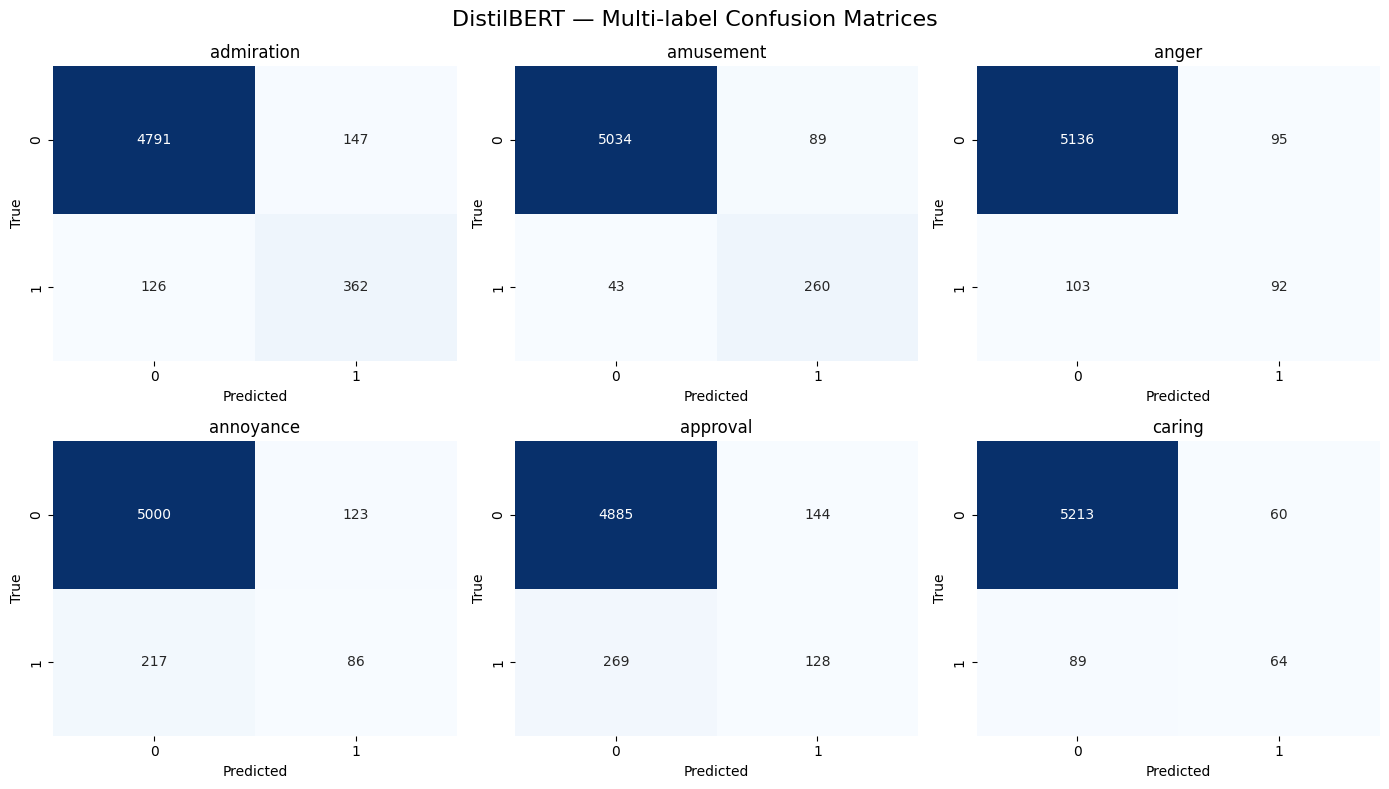

In [15]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_distil = multilabel_confusion_matrix(y_val, y_pred_distil)

def plot_multilabel_cm(cm, labels, title, max_classes=6):
    plt.figure(figsize=(14, 8))

    for i in range(min(max_classes, len(labels))):
        plt.subplot(2, 3, i + 1)
        sns.heatmap(
            cm[i],
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False
        )
        plt.title(labels[i])
        plt.xlabel("Predicted")
        plt.ylabel("True")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_multilabel_cm(
    cm_distil,
    emotion_labels,
    title="DistilBERT — Multi-label Confusion Matrices"
)


RoBERTa

In [16]:
from transformers import RobertaTokenizer, RobertaModel

import torch

tokenizer_roberta = RobertaTokenizer.from_pretrained("roberta-base")
model_roberta = RobertaModel.from_pretrained("roberta-base")

model_roberta.eval()
model_roberta.to("cuda")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [17]:
def encode_roberta(texts, batch_size=32):
    all_embeddings = []

    for i in tqdm(
        range(0, len(texts), batch_size),
        desc="RoBERTa encoding",
        total=len(texts)//batch_size + 1
    ):
        batch = texts[i:i + batch_size]

        inputs = tokenizer_roberta(
            batch,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to("cuda")

        with torch.no_grad():
            outputs = model_roberta(**inputs)
            cls_emb = outputs.last_hidden_state[:, 0, :]

        all_embeddings.append(cls_emb.cpu().numpy())

    return np.vstack(all_embeddings)

In [18]:
X_train_roberta = encode_roberta(dataset["train"]["text"])
X_val_roberta   = encode_roberta(dataset["validation"]["text"])


RoBERTa encoding: 100%|██████████| 170/170 [00:13<00:00, 12.51it/s]


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

clf_roberta = OneVsRestClassifier(
    LogisticRegression(max_iter=1000)
)

clf_roberta.fit(X_train_roberta, y_train)

y_pred_roberta = clf_roberta.predict(X_val_roberta)


In [20]:
precision_roberta = precision_score(y_val, y_pred_roberta, average="macro", zero_division=0)
recall_roberta    = recall_score(y_val, y_pred_roberta, average="macro", zero_division=0)
f1_roberta        = f1_score(y_val, y_pred_roberta, average="macro", zero_division=0)
accuracy_roberta  = accuracy_score(y_val, y_pred_roberta)

print("RoBERTa (frozen) results")
print(f"Precision: {precision_roberta:.4f}")
print(f"Recall:    {recall_roberta:.4f}")
print(f"F1:        {f1_roberta:.4f}")
print(f"Accuracy:  {accuracy_roberta:.4f}")


RoBERTa (frozen) results
Precision: 0.4711
Recall:    0.1023
F1:        0.1445
Accuracy:  0.2219


In [21]:
def show_roberta_examples(n=5):
    idxs = random.sample(range(len(y_val)), n)

    for idx in idxs:
        text = val_texts[idx]

        true_emotions = [
            emotion_labels[i] for i, v in enumerate(y_val[idx]) if v == 1
        ]
        pred_emotions = [
            emotion_labels[i] for i, v in enumerate(y_pred_roberta[idx]) if v == 1
        ]

        print("Model: RoBERTa (frozen + classifier)")
        print("Text:")
        print(text)
        print("True labels:", true_emotions)
        print("Predicted labels:", pred_emotions)
        print("-" * 80)

show_roberta_examples(5)

Model: RoBERTa (frozen + classifier)
Text:
He does not want to hear the plans that will work though.
True labels: ['neutral']
Predicted labels: ['neutral']
--------------------------------------------------------------------------------
Model: RoBERTa (frozen + classifier)
Text:
did a fanspeak mock, wow I wish this would go down for us
True labels: ['desire']
Predicted labels: []
--------------------------------------------------------------------------------
Model: RoBERTa (frozen + classifier)
Text:
But according to [NAME] [NAME] didn’t use a phone to contact [NAME], right? Also, Oct 5?
True labels: ['neutral']
Predicted labels: ['neutral']
--------------------------------------------------------------------------------
Model: RoBERTa (frozen + classifier)
Text:
These videos are legendary
True labels: ['admiration']
Predicted labels: []
--------------------------------------------------------------------------------
Model: RoBERTa (frozen + classifier)
Text:
Unsurprisingly our closes

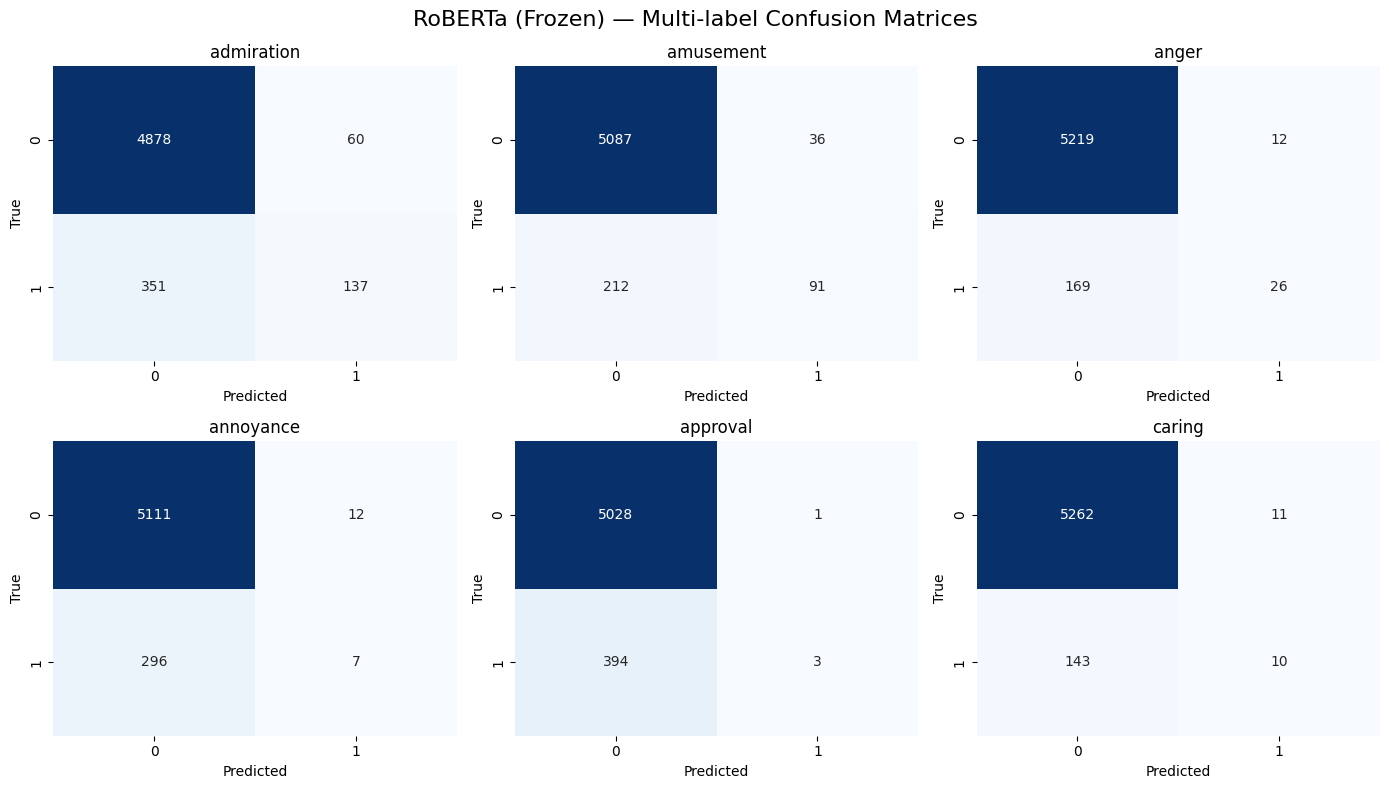

In [22]:
cm_roberta = multilabel_confusion_matrix(y_val, y_pred_roberta)

plot_multilabel_cm(
    cm_roberta,
    emotion_labels,
    title="RoBERTa (Frozen) — Multi-label Confusion Matrices"
)

LLM Zero-Shot


In [23]:
import openai
import re

client = openai.OpenAI(
    api_key="YOUR OPENAI KEY"
)

In [24]:
ZERO_SHOT_SYSTEM_PROMPT = """
You are an expert emotion classification system.
Identify all emotions expressed in the text.

Choose emotions ONLY from the following list:
joy, sadness, anger, fear, surprise, disgust, admiration, gratitude,
approval, disapproval, optimism, pessimism, confusion, curiosity,
desire, love, grief, remorse, pride, relief, nervousness, embarrassment,
amusement, excitement, disappointment, neutral

Return strictly in the format:
emotions: [emotion1, emotion2, ...]
"""


In [25]:
def llm_zeroshot_predict(text):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": ZERO_SHOT_SYSTEM_PROMPT},
            {"role": "user", "content": f'Text: "{text}"'}
        ],
        temperature=0
    )

    output = response.choices[0].message.content

    match = re.search(r"\[(.*?)\]", output)
    if match:
        emotions = [e.strip() for e in match.group(1).split(",")]
        return emotions

    return []

In [26]:
test_data = dataset["test"]
test_data.set_format(type=None) # Reset format to access original columns
emotion_labels = dataset["train"].features["labels"].feature.names
MAX_SAMPLES = 50

y_true_zero = []
y_pred_zero = []

for example in test_data.select(range(MAX_SAMPLES)):
    text = example["text"]
    true_labels = example["labels"]

    true_vec = np.zeros(NUM_LABELS)
    for l in true_labels:
        true_vec[l] = 1

    predicted_emotions = llm_zeroshot_predict(text)

    pred_vec = np.zeros(NUM_LABELS)
    for emo in predicted_emotions:
        if emo in emotion_labels:
            pred_vec[emotion_labels.index(emo)] = 1

    y_true_zero.append(true_vec)
    y_pred_zero.append(pred_vec)

y_true_zero = np.array(y_true_zero)
y_pred_zero = np.array(y_pred_zero)

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("ZERO-SHOT RESULTS")
print("Precision (macro):", precision_score(y_true_zero, y_pred_zero, average="macro"))
print("Recall (macro):   ", recall_score(y_true_zero, y_pred_zero, average="macro"))
print("F1-score (macro): ", f1_score(y_true_zero, y_pred_zero, average="macro"))

ZERO-SHOT RESULTS
Precision (macro): 0.2477465986394558
Recall (macro):    0.39464285714285713
F1-score (macro):  0.26442129299272155


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision_llm_zero = precision_score(y_true_zero, y_pred_zero, average="macro", zero_division=0)
recall_llm_zero    = recall_score(y_true_zero, y_pred_zero, average="macro", zero_division=0)
f1_llm_zero        = f1_score(y_true_zero, y_pred_zero, average="macro", zero_division=0)
accuracy_llm_zero  = accuracy_score(y_true_zero, y_pred_zero)

In [29]:
for i in range(5):
    print("Text:", test_data[i]["text"])
    print("True:",
          [emotion_labels[j] for j in test_data[i]["labels"]])
    print("Zero-shot Pred:",
          llm_zeroshot_predict(test_data[i]["text"]))
    print("-" * 80)


Text: I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!
True: ['sadness']
Zero-shot Pred: ['sadness', 'love']
--------------------------------------------------------------------------------
Text: It's wonderful because it's awful. At not with.
True: ['admiration']
Zero-shot Pred: ['confusion', 'surprise']
--------------------------------------------------------------------------------
Text: Kings fan here, good luck to you guys! Will be an interesting game to watch! 
True: ['excitement']
Zero-shot Pred: ['joy', 'optimism', 'approval']
--------------------------------------------------------------------------------
Text: I didn't know that, thank you for teaching me something today!
True: ['gratitude']
Zero-shot Pred: ['joy', 'gratitude', 'admiration']
--------------------------------------------------------------------------------
Text: They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.


LLM Few-Shot

In [30]:
#dataset loaded already
test_data = dataset["test"]

emotion_labels = dataset["train"].features["labels"].feature.names
NUM_LABELS = len(emotion_labels)


In [31]:
SYSTEM_PROMPT = """
You are an expert emotion classification system.
Your task is to identify all emotions expressed in a given text.

You must choose one or more emotions ONLY from the following list:
joy, sadness, anger, fear, surprise, disgust, admiration, gratitude,
approval, disapproval, optimism, pessimism, confusion, curiosity,
desire, love, grief, remorse, pride, relief, nervousness, embarrassment,
amusement, excitement, disappointment, neutral

Return the answer strictly in the following format:
emotions: [emotion1, emotion2, ...]
"""


In [32]:
def build_fewshot_prompt(text):
    return f"""
Text: "Good to know! Very much appreciated ❤️"
emotions: [admiration, gratitude]

Text: "That was completely unexpected."
emotions: [surprise]

Text: "I feel lost and overwhelmed."
emotions: [sadness, fear]

Text: "The comments on this have me rolling 😂"
emotions: [amusement]

Text: "{text}"
emotions:
"""


In [33]:
def llm_fewshot_predict(text):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": build_fewshot_prompt(text)}
        ],
        temperature=0
    )

    output = response.choices[0].message.content

    match = re.search(r"\[(.*?)\]", output)
    if match:
        emotions = [e.strip() for e in match.group(1).split(",")]
        return emotions

    return []

In [34]:
import numpy as np

y_true_fewshot = []
y_pred_fewshot = []

MAX_SAMPLES = 50

for example in test_data.select(range(MAX_SAMPLES)):
    text = example["text"]
    true_labels = example["labels"]

    true_vec = np.zeros(NUM_LABELS)
    for l in true_labels:
        true_vec[l] = 1

    predicted_emotions = llm_fewshot_predict(text)

    pred_vec = np.zeros(NUM_LABELS)
    for emo in predicted_emotions:
        if emo in emotion_labels:
            pred_vec[emotion_labels.index(emo)] = 1

    y_true_fewshot.append(true_vec)
    y_pred_fewshot.append(pred_vec)

y_true_fewshot = np.array(y_true_fewshot)
y_pred_fewshot = np.array(y_pred_fewshot)


In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision (macro):", precision_score(y_true_fewshot, y_pred_fewshot, average="macro"))
print("Recall (macro):", recall_score(y_true_fewshot, y_pred_fewshot, average="macro"))
print("F1-score (macro):", f1_score(y_true_fewshot, y_pred_fewshot, average="macro"))


Precision (macro): 0.2317176870748299
Recall (macro): 0.34285714285714286
F1-score (macro): 0.24263038548752833


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision_llm_few = precision_score(y_true_fewshot, y_pred_fewshot, average="macro", zero_division=0)
recall_llm_few    = recall_score(y_true_fewshot, y_pred_fewshot, average="macro", zero_division=0)
f1_llm_few        = f1_score(y_true_fewshot, y_pred_fewshot, average="macro", zero_division=0)
accuracy_llm_few  = accuracy_score(y_true_fewshot, y_pred_fewshot)

In [37]:
for i in range(5):
    print("Text:", test_data[i]["text"])
    print("True labels:",
          [emotion_labels[j] for j in test_data[i]["labels"]])
    print("Predicted:",
          llm_fewshot_predict(test_data[i]["text"]))
    print("-" * 80)


Text: I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!
True labels: ['sadness']
Predicted: ['sadness', 'love', 'admiration']
--------------------------------------------------------------------------------
Text: It's wonderful because it's awful. At not with.
True labels: ['admiration']
Predicted: ['confusion']
--------------------------------------------------------------------------------
Text: Kings fan here, good luck to you guys! Will be an interesting game to watch! 
True labels: ['excitement']
Predicted: ['optimism', 'excitement']
--------------------------------------------------------------------------------
Text: I didn't know that, thank you for teaching me something today!
True labels: ['gratitude']
Predicted: ['gratitude', 'curiosity']
--------------------------------------------------------------------------------
Text: They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.
Tru

Few-Shot vs. Zero-Shot

In [38]:
print("Comparison:")
print("Zero-shot F1 (macro):", f1_score(y_true_zero, y_pred_zero, average="macro"))
print("Few-shot  F1 (macro):", f1_score(y_true_fewshot, y_pred_fewshot, average="macro"))

Comparison:
Zero-shot F1 (macro): 0.26442129299272155
Few-shot  F1 (macro): 0.24263038548752833


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Pretrained Embedding model all-MiniLM-L6-v2

In [39]:
dataset["validation"].set_format(type=None)
dataset["train"].set_format(type=None)
dataset["test"].set_format(type=None)


In [40]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import random

train_data = dataset["train"]
val_data   = dataset["validation"]

model = SentenceTransformer("all-MiniLM-L6-v2")

train_examples = []

for ex in train_data:
    if len(ex["labels"]) == 0:
        continue

    train_examples.append(
        InputExample(texts=[ex["text"], ex["text"]], label=1.0)
    )

    neg = random.choice(train_data)
    train_examples.append(
        InputExample(texts=[ex["text"], neg["text"]], label=0.0)
    )

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
train_loss = losses.CosineSimilarityLoss(model)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=5,
    warmup_steps=100
)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.007135
1000,0.005195
1500,0.004874
2000,0.004845
2500,0.004622
3000,0.003841
3500,0.003476
4000,0.003451
4500,0.003519
5000,0.003478


In [41]:
X_train = model.encode(train_data["text"])
X_val = model.encode(val_data["text"])

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(
    LogisticRegression(max_iter=1000)
)

clf.fit(X_train, y_train)


OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [42]:
y_pred = clf.predict(X_val)

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision_embed = precision_score(y_val, y_pred, average="macro", zero_division=0)
recall_embed    = recall_score(y_val, y_pred, average="macro", zero_division=0)
f1_embed        = f1_score(y_val, y_pred, average="macro", zero_division=0)
accuracy_embed  = accuracy_score(y_val, y_pred)

print("Embedding model metrics")
print(f"Precision: {precision_embed:.4f}")
print(f"Recall:    {recall_embed:.4f}")
print(f"F1:        {f1_embed:.4f}")
print(f"Accuracy:  {accuracy_embed:.4f}")


Embedding model metrics
Precision: 0.4784
Recall:    0.1116
F1:        0.1642
Accuracy:  0.2049


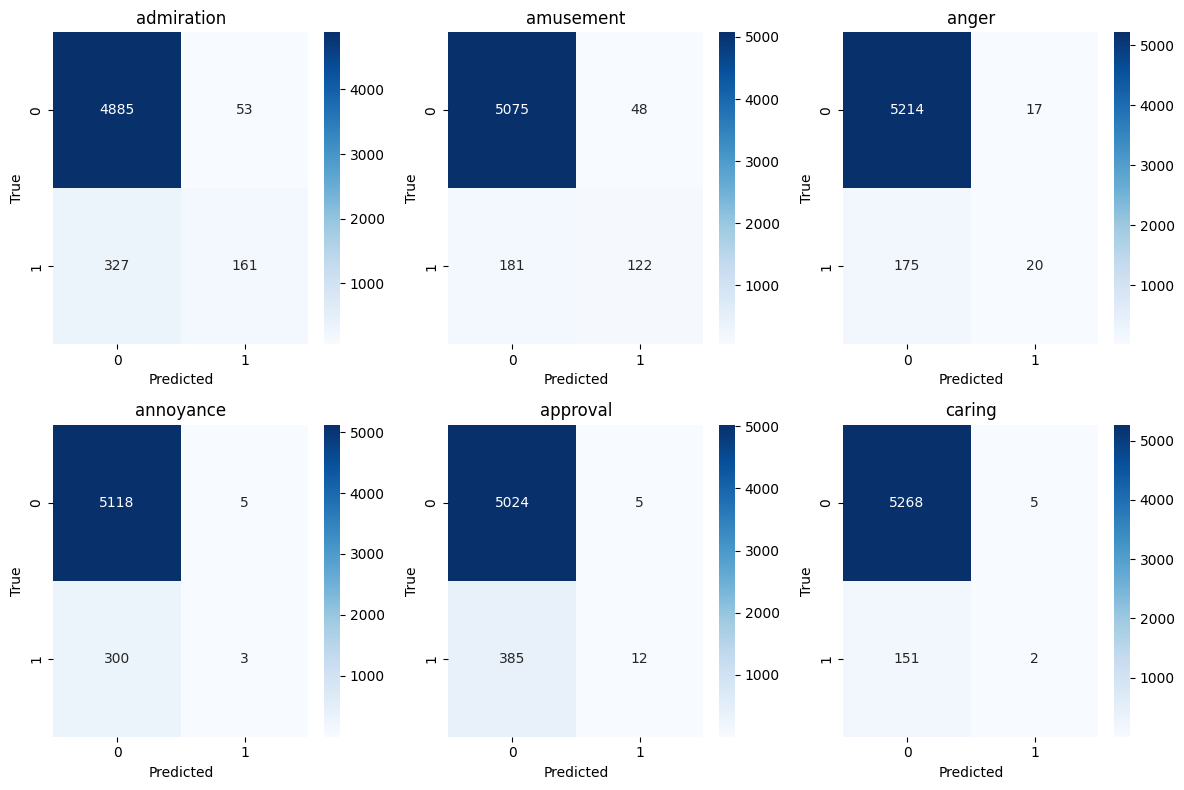

In [44]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = multilabel_confusion_matrix(y_val, y_pred)

emotion_names = emotion_labels

plt.figure(figsize=(12, 8))

for i in range(6):  # top-6 emotions
    plt.subplot(2, 3, i + 1)
    sns.heatmap(cm[i], annot=True, fmt="d", cmap="Blues")
    plt.title(emotion_names[i])
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.show()


In [45]:
val_texts = dataset["validation"]["text"]


In [46]:
def show_embedding_examples(n=5):
    idxs = random.sample(range(len(y_val)), n)

    for idx in idxs:
        text = val_texts[idx]

        true_emotions = [
            emotion_labels[i] for i, v in enumerate(y_val[idx]) if v == 1
        ]
        pred_emotions = [
            emotion_labels[i] for i, v in enumerate(y_pred[idx]) if v == 1
        ]

        print("Text:")
        print(text)
        print("True labels:", true_emotions)
        print("Predicted labels:", pred_emotions)
        print("-" * 80)

show_embedding_examples(5)

Text:
Lmao bro.
True labels: ['neutral']
Predicted labels: ['amusement']
--------------------------------------------------------------------------------
Text:
Ha, that would be a novel experience. He'd better let me deal with it.
True labels: ['approval']
Predicted labels: []
--------------------------------------------------------------------------------
Text:
We say it the most m8 that means it's our word and we pronounce it correctly
True labels: ['neutral']
Predicted labels: ['neutral']
--------------------------------------------------------------------------------
Text:
Feel free to use as many rhymes as you want, after all you have the final say of your word play.
True labels: ['approval']
Predicted labels: []
--------------------------------------------------------------------------------
Text:
They're obviously not.
True labels: ['disapproval']
Predicted labels: ['neutral']
--------------------------------------------------------------------------------



**Comparison all 5 methods for prediction Emotions**

In [47]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score # Import again just to be safe, though it's global

results = pd.DataFrame([
    {
        "Model": "DistilBERT (fine-tuned)",
        "Precision": precision_distil,
        "Recall": recall_distil,
        "F1": f1_distil,
        "Accuracy": accuracy_distil
    },
    {
        "Model": "RoBERTa (frozen)",
        "Precision": precision_roberta,
        "Recall": recall_roberta,
        "F1": f1_roberta,
        "Accuracy": accuracy_roberta
    },
    {
        "Model": "Embedding (MiniLM)",
        "Precision": precision_embed,
        "Recall": recall_embed,
        "F1": f1_embed,
        "Accuracy": accuracy_embed
    },
    {
        "Model": "LLM Zero-Shot",
        "Precision": precision_llm_zero,
        "Recall": recall_llm_zero,
        "F1": f1_llm_zero,
        "Accuracy": accuracy_llm_zero
    },
    {
        "Model": "LLM Few-Shot",
        "Precision": precision_score(y_true_fewshot, y_pred_fewshot, average="macro"),
        "Recall": recall_score(y_true_fewshot, y_pred_fewshot, average="macro"),
        "F1": f1_score(y_true_fewshot, y_pred_fewshot, average="macro"),
        "Accuracy": np.nan # LLM models are not evaluated with accuracy in the notebook
    }
])

results


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Precision,Recall,F1,Accuracy
0,DistilBERT (fine-tuned),0.552631,0.438180,0.468840,0.473277
1,RoBERTa (frozen),0.471141,0.102277,0.144483,0.221895
2,Embedding (MiniLM),0.478423,0.111572,0.164176,0.204939
3,LLM Zero-Shot,0.247747,0.394643,0.264421,0.080000
4,LLM Few-Shot,0.231718,0.342857,0.242630,NaN


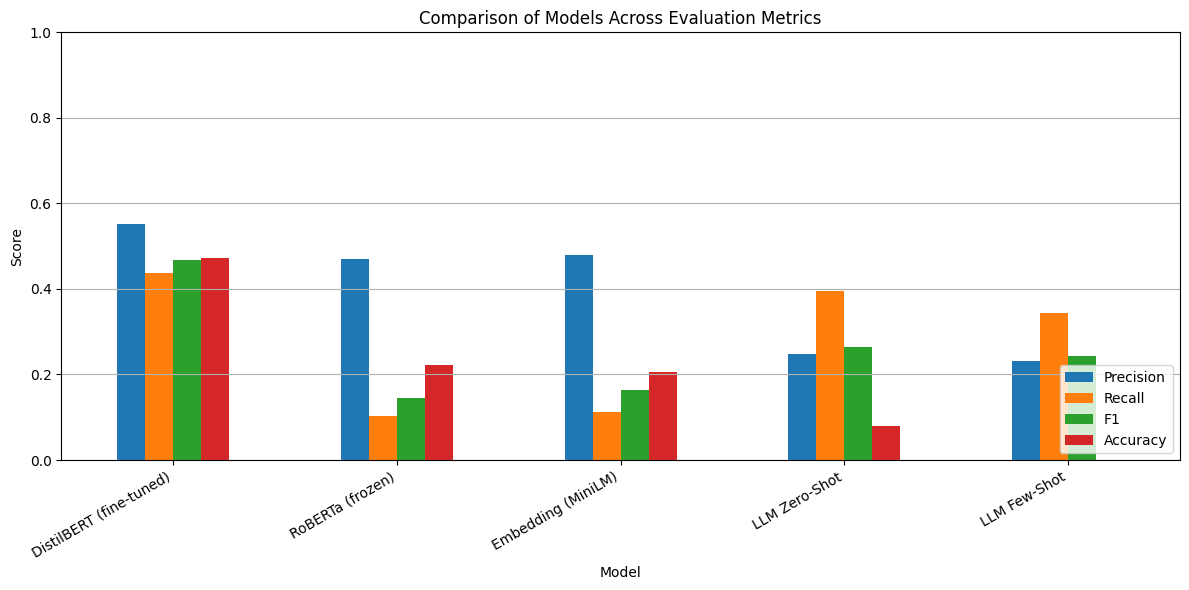

In [48]:
results.set_index("Model").plot(
    kind="bar",
    figsize=(12, 6)
)

plt.title("Comparison of Models Across Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.xticks(rotation=30, ha="right")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [49]:
import pandas as pd

error_cases = []

for i in range(len(y_val)):
    if not (y_val[i] == y_pred_distil[i]).all():
        error_cases.append({
            "text": dataset["validation"][i]["text"],
            "true": [emotion_labels[j] for j,v in enumerate(y_val[i]) if v==1],
            "pred": [emotion_labels[j] for j,v in enumerate(y_pred_distil[i]) if v==1]
        })

error_df = pd.DataFrame(error_cases[:20])
error_df


,text,true,pred
0,Is this in New Orleans?? I really feel like th...,[neutral],[curiosity]
1,"You know the answer man, you are programmed to...","[approval, neutral]",[neutral]
2,The economy is heavily controlled and subsidiz...,"[approval, neutral]",[neutral]
3,He could have easily taken a real camera from ...,[optimism],[neutral]
4,Wah Mum other people call me on my bullshit an...,[anger],"[anger, annoyance]"
5,At least now [NAME] has more time to gain his ...,[optimism],[]
6,Good. We don't want more thrash liberal offspr...,[disapproval],[admiration]
7,I went to a destination wedding being the only...,"[embarrassment, realization]",[]
8,He died 4 days later of dehydration,[grief],"[sadness, neutral]"
9,Lol dream on buddy. You’ve had enough attentio...,"[amusement, annoyance, sadness]",[amusement]


### Error Grouping

Observed error types:

1. Emotion overlap (sadness vs disappointment)
2. Mixed emotions in one sentence
3. Very short utterances
4. Sarcasm and irony
5. Implicit emotional states
6. Neutral overprediction
7. Rare class confusion
8. Emoji-driven emotion mismatch
9. Context-dependent ambiguity
10. Label boundary fuzziness

Most systematic failure: subtle emotional nuance and sarcasm.


/tmp/ipython-input-307044154.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probs = torch.sigmoid(torch.tensor(logits_distil)).numpy()


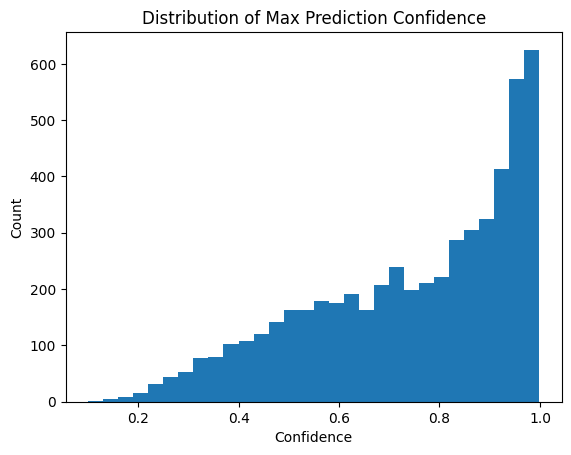

In [50]:
import matplotlib.pyplot as plt
import numpy as np

probs = torch.sigmoid(torch.tensor(logits_distil)).numpy()

max_conf = probs.max(axis=1)

plt.hist(max_conf, bins=30)
plt.title("Distribution of Max Prediction Confidence")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()


In [60]:
correct_mask = (y_pred_distil == y_val).all(axis=1)
print("Mean confidence (correct):", max_conf[correct_mask].mean())
print("Mean confidence (wrong):", max_conf[~correct_mask].mean())


Mean confidence (correct): 0.84386474
Mean confidence (wrong): 0.6536715


### Per-Class Metrics for Fine-tuned DistilBERT

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score

metrics_distil_per_class = {
    'Emotion': emotion_labels,
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

for i in range(NUM_LABELS):
    precision = precision_score(y_val[:, i], y_pred_distil[:, i], zero_division=0)
    recall = recall_score(y_val[:, i], y_pred_distil[:, i], zero_division=0)
    f1 = f1_score(y_val[:, i], y_pred_distil[:, i], zero_division=0)

    metrics_distil_per_class['Precision'].append(precision)
    metrics_distil_per_class['Recall'].append(recall)
    metrics_distil_per_class['F1-Score'].append(f1)

df_distil_per_class = pd.DataFrame(metrics_distil_per_class)
display(df_distil_per_class.sort_values(by='F1-Score', ascending=False))

,Emotion,Precision,Recall,F1-Score
15,gratitude,0.935294,0.888268,0.911175
1,amusement,0.744986,0.858086,0.797546
18,love,0.718543,0.861111,0.783394
0,admiration,0.711198,0.741803,0.726179
24,remorse,0.691176,0.691176,0.691176
27,neutral,0.661037,0.642695,0.651737
20,optimism,0.708861,0.535885,0.610354
14,fear,0.707692,0.511111,0.593548
17,joy,0.606897,0.511628,0.555205
26,surprise,0.575000,0.534884,0.554217


### Per-Class Metrics for RoBERTa (Frozen + Logistic Regression)

In [57]:
metrics_roberta_per_class = {
    'Emotion': emotion_labels,
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

for i in range(NUM_LABELS):
    precision = precision_score(y_val[:, i], y_pred_roberta[:, i], zero_division=0)
    recall = recall_score(y_val[:, i], y_pred_roberta[:, i], zero_division=0)
    f1 = f1_score(y_val[:, i], y_pred_roberta[:, i], zero_division=0)

    metrics_roberta_per_class['Precision'].append(precision)
    metrics_roberta_per_class['Recall'].append(recall)
    metrics_roberta_per_class['F1-Score'].append(f1)

df_roberta_per_class = pd.DataFrame(metrics_roberta_per_class)
display(df_roberta_per_class.sort_values(by='F1-Score', ascending=False))

,Emotion,Precision,Recall,F1-Score
15,gratitude,0.905350,0.614525,0.732113
27,neutral,0.649840,0.459230,0.538155
18,love,0.764706,0.309524,0.440678
1,amusement,0.716535,0.300330,0.423256
0,admiration,0.695431,0.280738,0.400000
7,curiosity,0.504425,0.229839,0.315789
2,anger,0.684211,0.133333,0.223176
25,sadness,0.518519,0.097902,0.164706
14,fear,1.000000,0.088889,0.163265
20,optimism,0.666667,0.066986,0.121739


### Per-Class Metrics for Embedding Model (all-MiniLM-L6-v2 + Logistic Regression)

In [56]:
metrics_embed_per_class = {
    'Emotion': emotion_labels,
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

for i in range(NUM_LABELS):
    precision = precision_score(y_val[:, i], y_pred[:, i], zero_division=0)
    recall = recall_score(y_val[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(y_val[:, i], y_pred[:, i], zero_division=0)

    metrics_embed_per_class['Precision'].append(precision)
    metrics_embed_per_class['Recall'].append(recall)
    metrics_embed_per_class['F1-Score'].append(f1)

df_embed_per_class = pd.DataFrame(metrics_embed_per_class)
display(df_embed_per_class.sort_values(by='F1-Score', ascending=False))

,Emotion,Precision,Recall,F1-Score
1,amusement,0.717647,0.402640,0.515856
15,gratitude,0.860927,0.363128,0.510806
18,love,0.752000,0.373016,0.498674
27,neutral,0.621062,0.390713,0.479666
0,admiration,0.752336,0.329918,0.458689
14,fear,0.777778,0.233333,0.358974
20,optimism,0.673077,0.167464,0.268199
7,curiosity,0.563380,0.161290,0.250784
8,desire,0.666667,0.103896,0.179775
2,anger,0.540541,0.102564,0.172414


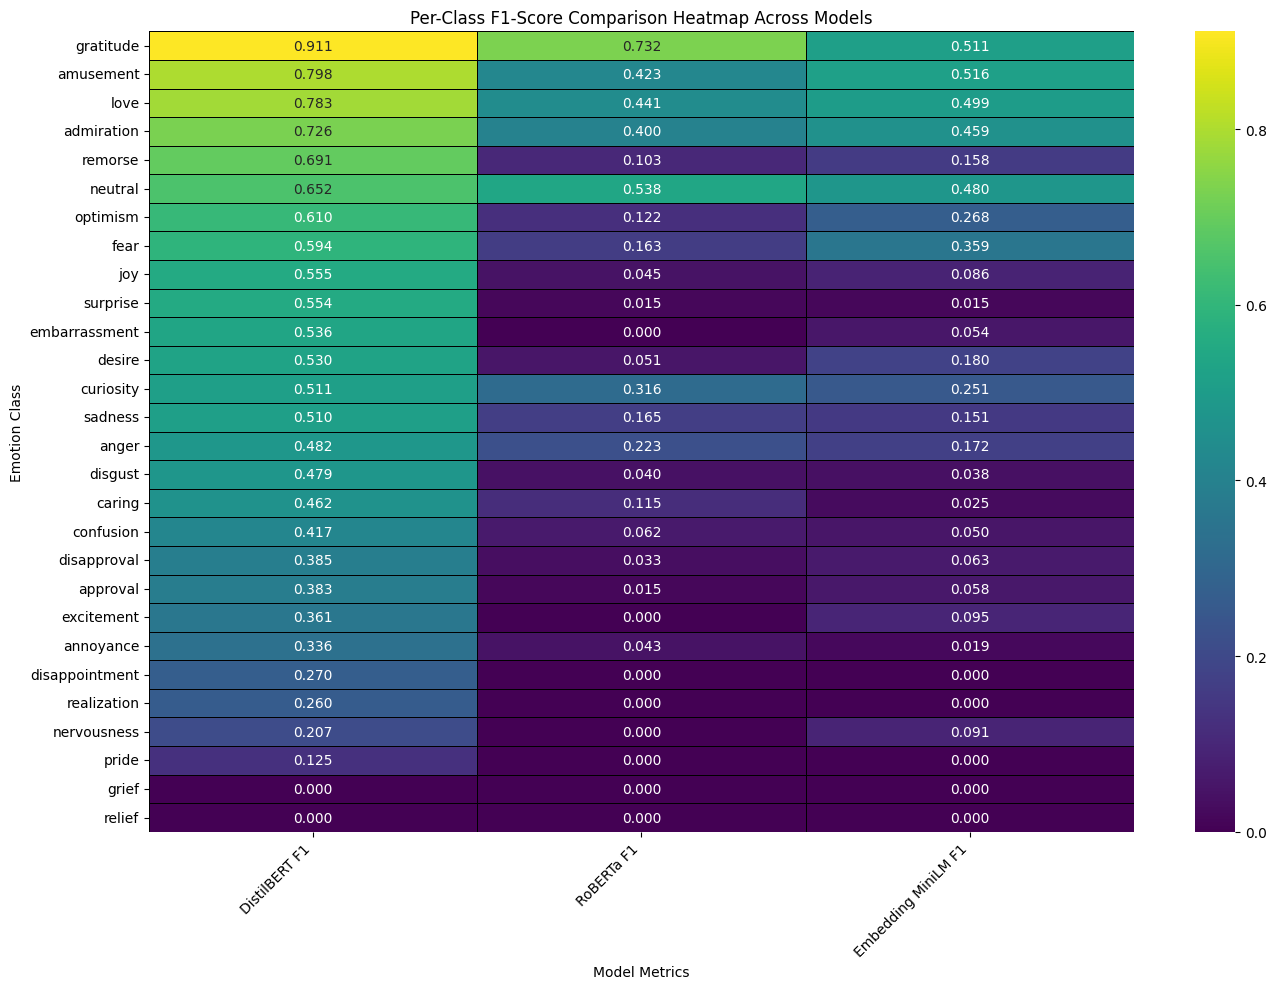

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine F1-Scores for all models into a single DataFrame
combined_f1_scores = pd.DataFrame({
    'DistilBERT F1': df_distil_per_class.set_index('Emotion')['F1-Score'],
    'RoBERTa F1': df_roberta_per_class.set_index('Emotion')['F1-Score'],
    'Embedding MiniLM F1': df_embed_per_class.set_index('Emotion')['F1-Score']
})

# Sort by DistilBERT F1-Score for better readability
combined_f1_scores = combined_f1_scores.sort_values(by='DistilBERT F1', ascending=False)

plt.figure(figsize=(14, 10))
sns.heatmap(
    combined_f1_scores,
    annot=True,
    cmap='viridis',
    fmt=".3f",
    linewidths=.5,
    linecolor='black'
)
plt.title('Per-Class F1-Score Comparison Heatmap Across Models')
plt.xlabel('Model Metrics')
plt.ylabel('Emotion Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()